Processed 12 PID segments and 12 input plumes
Processed 12 deconvolved segments
Average PID AUC: 4.4437
Average Input AUC: 3.0942
Average Deconvolved AUC: 1.2755


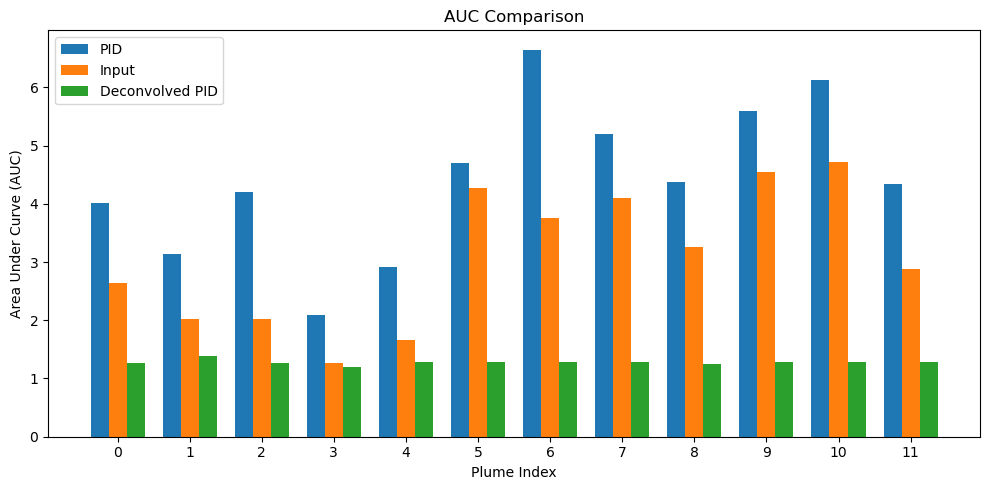

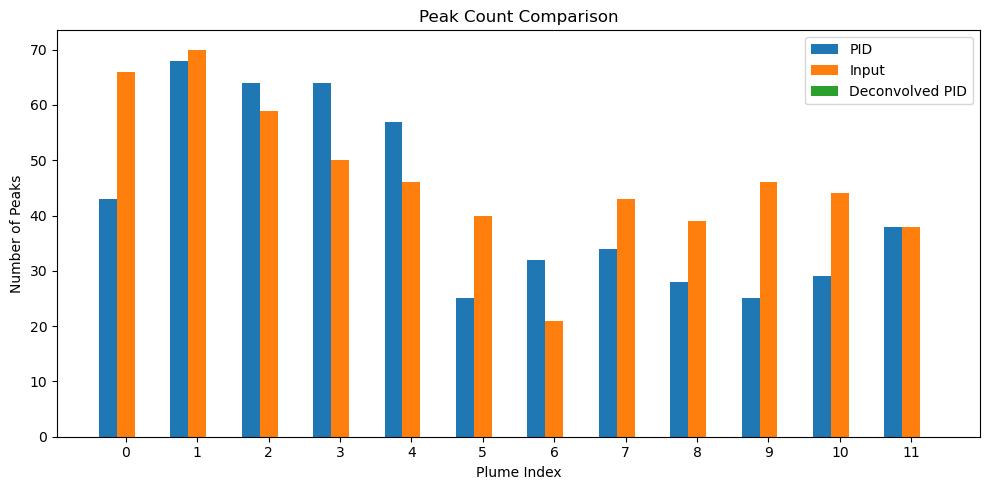

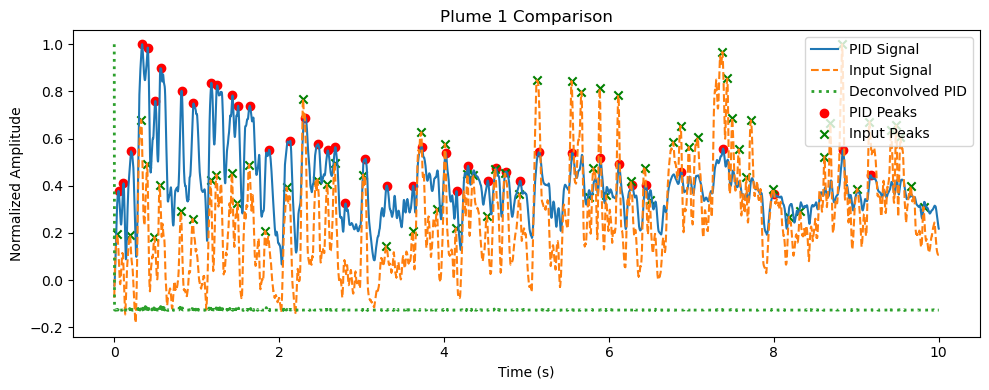

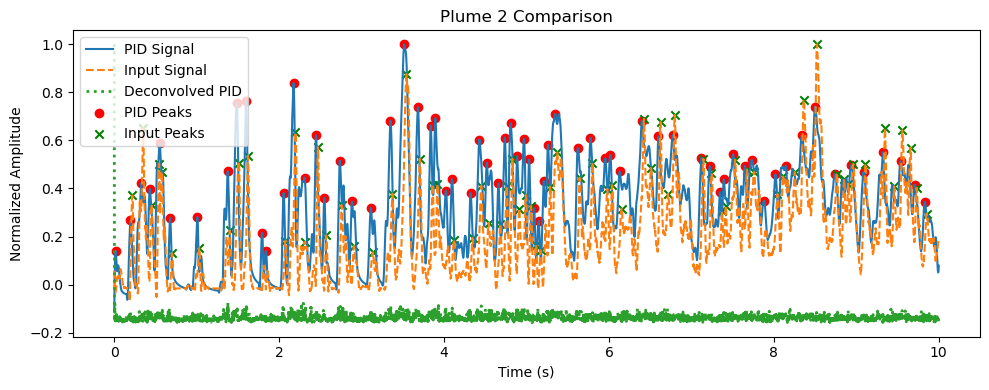

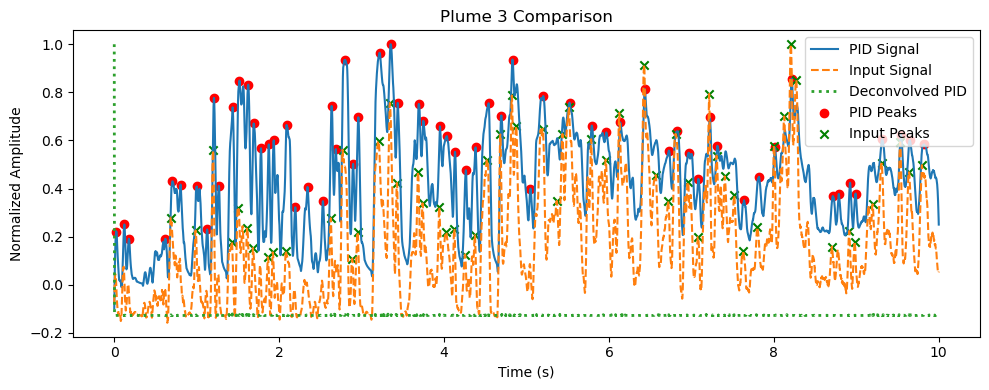

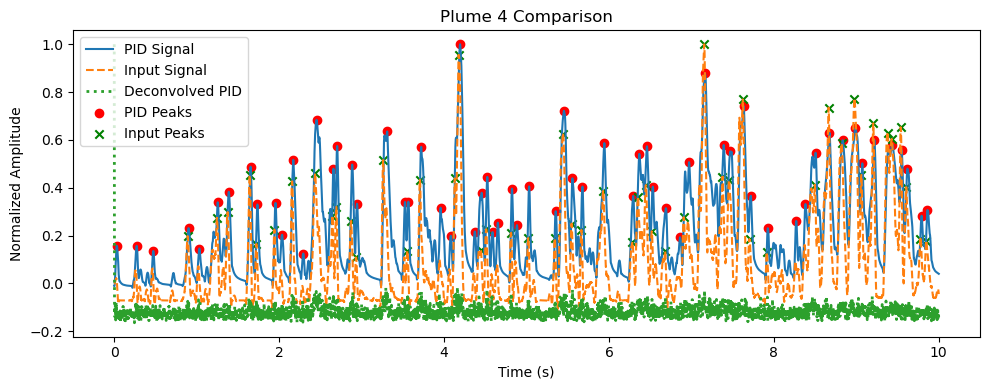

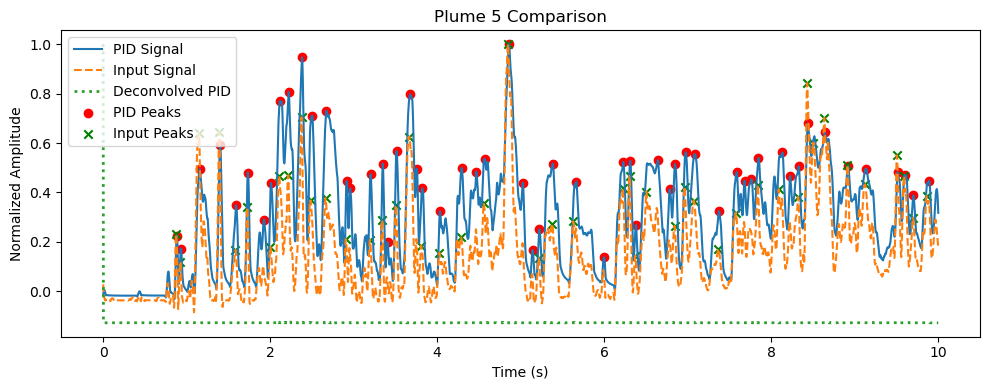

In [6]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
from scipy.fft import fft, ifft
from scipy.ndimage import gaussian_filter1d
from glob import glob

# Configuration Flags
CONFIG = {
    'BASELINE_CORRECTION': True,
    'SMOOTHING': True,
    'NORMALIZATION': True,
    'PEAK_DETECTION': True,
    'DECONVOLUTION': True,         # Enable deconvolution analysis
    'PLOT_SIGNALS': True,          # Plot signal comparisons
    'PLOT_METRICS': True,          # Plot AUC and peak metrics
    'MAX_PLOTS': 5                 # Max plumes to plot
}

# Constants
SAMPLE_RATE = 10000  # Hz
DURATION_S = 10      # Plume duration in seconds
BL_POINTS = 100      # Baseline correction points
WINDOW_LEN = 500     # Savitzky-Golay window length
POLY_ORDER = 3       # Savitzky-Golay polynomial order

# Processing parameters
PID_PARAMS = {
    'THRESH': 0.1,   # Peak detection threshold ratio
    'PROM': 0.1,     # Minimum peak prominence
    'MIN_DIST': 0.02  # Minimum peak distance (s)
}

INPUT_PARAMS = {
    'THRESH': 0.1,   # Peak detection threshold ratio
    'PROM': 0.14,    # Minimum peak prominence
    'MIN_DIST': 0.02  # Minimum peak distance (s)
}

# Deconvolution parameters
DECONV_PARAMS = {
    'method': 'fft',          # 'fft' or 'wiener'
    'kernel_type': 'pid',     # 'pid' or 'mox'
    'tau1': 1.0,              # Decay constant (s)
    'tau2': 0.05,             # Rise constant (s)
    'smooth_sigma': 9,        # Gaussian smoothing sigma
    'calibrate': True         # Enable amplitude calibration
}

def load_pid_data(filepath):
    """Load PID and Input_Pulse data from HDF5 file"""
    with h5py.File(filepath, 'r') as f:
        pid = np.array(f['PID']['values']).squeeze()
        input_pulse = np.array(f['Input_Pulse']['values']).squeeze().astype(float)
    return pid, input_pulse

def load_input_data(filepath):
    """Load input plume data from HDF5 file"""
    with h5py.File(filepath, 'r') as f:
        plume = np.array(f['plume']).squeeze().astype(float)
    return plume

def apply_processing_pipeline(signal, params):
    """Apply processing steps based on configuration flags"""
    time = np.arange(len(signal)) / SAMPLE_RATE
    
    # Processing pipeline
    if CONFIG['BASELINE_CORRECTION']:
        signal = signal - np.mean(signal[:BL_POINTS])
    
    if CONFIG['SMOOTHING']:
        signal = savgol_filter(signal, WINDOW_LEN, POLY_ORDER)
    
    if CONFIG['NORMALIZATION']:
        signal = signal / np.max(np.abs(signal))
    
    # Peak detection
    peaks_df = pd.DataFrame(columns=['time', 'amplitude'])
    if CONFIG['PEAK_DETECTION']:
        height = params['THRESH'] * np.max(signal)
        distance = int(params['MIN_DIST'] * SAMPLE_RATE)
        peaks, _ = find_peaks(signal, height=height, 
                             prominence=params['PROM'], 
                             distance=distance)
        peaks_df = pd.DataFrame({
            'time': time[peaks], 
            'amplitude': signal[peaks]
        })
    
    return time, signal, peaks_df

def calculate_auc(signal, time):
    """Calculate area under the curve using trapezoidal rule"""
    return np.trapz(np.abs(signal), time)

def fft_deconvolution(sensor_signal, sample_rate, params):
    """
    Perform FFT-based deconvolution to recover original signal
    using a physical kernel model of the sensor response
    """
    n = len(sensor_signal)
    t = np.arange(n) / sample_rate
    
    # Create physical kernel model
    if params['kernel_type'] == 'pid':
        # Double exponential kernel for PID sensors
        kernel_vals = np.exp(-t/params['tau1']) - np.exp(-t/params['tau2'])

    # Normalize kernel
    kernel_vals = kernel_vals / np.max(kernel_vals)
    
    # FFT-based deconvolution
    fft_sensor = fft(sensor_signal)
    fft_kernel = fft(kernel_vals, n=n)
    
    # Regularized division
    fft_deconvolved = fft_sensor / (fft_kernel + 1e-10)
    deconvolved = np.real(ifft(fft_deconvolved))
    
    # Remove baseline drift
    deconvolved = deconvolved - np.mean(deconvolved[:BL_POINTS])
    
    # Clip negative values
    deconvolved = np.clip(deconvolved, 0, None)
    
    # Apply smoothing
    if params['smooth_sigma'] > 0:
        deconvolved = gaussian_filter1d(deconvolved, sigma=params['smooth_sigma'])
    
    return deconvolved


def calibrate_deconvolved(deconvolved, reference_signal):
    """Calibrate deconvolved signal to reference signal"""
    # Center signals
    ref_centered = reference_signal - np.mean(reference_signal)
    dec_centered = deconvolved - np.mean(deconvolved)
    
    # Calculate scaling factor
    scaling_factor = np.max(np.abs(ref_centered)) / np.max(np.abs(dec_centered))
    
    # Apply calibration
    return dec_centered * scaling_factor

def process_pid_file(pid_file):
    """Process PID file to extract and process all segments"""
    pid_segments = []
    decon_segments = []
    pid, input_pulse = load_pid_data(pid_file)
    
    # Detect triggers (rising edges)
    threshold = np.mean(input_pulse) + 3 * np.std(input_pulse)
    rising_edges = np.where(np.diff((input_pulse > threshold).astype(int)) == 1)[0]
    
    # Filter triggers to ensure proper spacing
    triggers = []
    if rising_edges.size > 0:
        triggers.append(rising_edges[0])
        for r in rising_edges[1:]:
            if r - triggers[-1] > DURATION_S * SAMPLE_RATE:
                triggers.append(r)
    
    # Process each segment
    for start in triggers:
        end = start + int(DURATION_S * SAMPLE_RATE)
        segment = pid[start:end]
        
        # Standard processing
        time, processed, peaks_df = apply_processing_pipeline(segment, PID_PARAMS)
        pid_segments.append({
            'time': time,
            'signal': processed,
            'peaks': peaks_df,
            'auc': calculate_auc(processed, time)
        })
        
        # Deconvolution processing
        if CONFIG['DECONVOLUTION']:
            # Apply baseline correction for deconvolution input
            segment_bc = segment - np.mean(segment[:BL_POINTS])
            
            # Select deconvolution method
            if DECONV_PARAMS['method'] == 'fft':
                decon = fft_deconvolution(
                    segment_bc, SAMPLE_RATE, DECONV_PARAMS
                )
            
            # Apply post-deconvolution processing
            if CONFIG['SMOOTHING'] and DECONV_PARAMS['method'] != 'fft':
                decon = savgol_filter(decon, WINDOW_LEN, POLY_ORDER)
            
            if CONFIG['BASELINE_CORRECTION']:
                decon = decon - np.mean(decon[:BL_POINTS])
            
            if CONFIG['NORMALIZATION']:
                decon = decon / np.max(np.abs(decon))
            
            # Peak detection for deconvolved signal
            peaks_df_decon = pd.DataFrame(columns=['time', 'amplitude'])
            if CONFIG['PEAK_DETECTION']:
                height = PID_PARAMS['THRESH'] * np.max(decon)
                distance = int(PID_PARAMS['MIN_DIST'] * SAMPLE_RATE)
                peaks, _ = find_peaks(decon, height=height, 
                                     prominence=PID_PARAMS['PROM'], 
                                     distance=distance)
                peaks_df_decon = pd.DataFrame({
                    'time': time[peaks], 
                    'amplitude': decon[peaks]
                })
            
            decon_segments.append({
                'time': time,
                'signal': decon,
                'peaks': peaks_df_decon,
                'auc': calculate_auc(decon, time)
            })
    
    return pid_segments, decon_segments

def process_input_files(input_folder):
    """Process all input plume files in directory"""
    input_segments = []
    input_files = sorted(glob(os.path.join(input_folder, '*.mat')))
    
    for input_file in input_files:
        plume = load_input_data(input_file)
        time, processed, peaks_df = apply_processing_pipeline(plume, INPUT_PARAMS)
        input_segments.append({
            'time': time,
            'signal': processed,
            'peaks': peaks_df,
            'auc': calculate_auc(processed, time)
        })
    
    return input_segments

def plot_metrics(pid_segments, input_segments, decon_segments=None):
    """Generate metrics comparison plots"""
    num_plumes = min(len(pid_segments), len(input_segments))
    indices = np.arange(num_plumes)
    
    # AUC comparison
    pid_auc = [seg['auc'] for seg in pid_segments[:num_plumes]]
    input_auc = [seg['auc'] for seg in input_segments[:num_plumes]]
    
    plt.figure(figsize=(10, 5))
    width = 0.25
    plt.bar(indices - width, pid_auc, width, label='PID')
    plt.bar(indices, input_auc, width, label='Input')
    
    if decon_segments and len(decon_segments) >= num_plumes:
        decon_auc = [seg['auc'] for seg in decon_segments[:num_plumes]]
        plt.bar(indices + width, decon_auc, width, label='Deconvolved PID')
    
    plt.xlabel('Plume Index')
    plt.ylabel('Area Under Curve (AUC)')
    plt.xticks(indices)
    plt.legend()
    plt.title('AUC Comparison')
    plt.tight_layout()
    plt.show()
    
    # Peak count comparison
    pid_peaks = [len(seg['peaks']) for seg in pid_segments[:num_plumes]]
    input_peaks = [len(seg['peaks']) for seg in input_segments[:num_plumes]]
    
    plt.figure(figsize=(10, 5))
    plt.bar(indices - width, pid_peaks, width, label='PID')
    plt.bar(indices, input_peaks, width, label='Input')
    
    if decon_segments and len(decon_segments) >= num_plumes:
        decon_peaks = [len(seg['peaks']) for seg in decon_segments[:num_plumes]]
        plt.bar(indices + width, decon_peaks, width, label='Deconvolved PID')
    
    plt.xlabel('Plume Index')
    plt.ylabel('Number of Peaks')
    plt.xticks(indices)
    plt.legend()
    plt.title('Peak Count Comparison')
    plt.tight_layout()
    plt.show()

def plot_signal_comparison(pid_seg, input_seg, decon_seg=None, title=''):
    """Plot signal comparison for a single plume"""
    plt.figure(figsize=(10, 4))
    
    # Plot PID and Input signals
    plt.plot(pid_seg['time'], pid_seg['signal'], label='PID Signal')
    plt.plot(input_seg['time'], input_seg['signal'], '--', label='Input Signal')
    
    # Plot deconvolved signal if available
    if decon_seg:
        plt.plot(decon_seg['time'], decon_seg['signal'], ':', 
                label='Deconvolved PID', linewidth=2)
    
    # Plot peaks
    if CONFIG['PEAK_DETECTION']:
        plt.scatter(pid_seg['peaks']['time'], pid_seg['peaks']['amplitude'], 
                    color='red', marker='o', label='PID Peaks')
        plt.scatter(input_seg['peaks']['time'], input_seg['peaks']['amplitude'], 
                    color='green', marker='x', label='Input Peaks')
        
        if decon_seg and not decon_seg['peaks'].empty:
            plt.scatter(decon_seg['peaks']['time'], decon_seg['peaks']['amplitude'], 
                        color='blue', marker='*', s=100, label='Deconvolved Peaks')
    
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Amplitude')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # File paths
    PID_FILE = r"C:\Users\amirr\Documents\Postdoc_Lab\Pub\L15\2-Heptanone\1_100\Plumes_10s.mat"
    INPUT_FOLDER = r"C:\Users\amirr\Documents\Postdoc_Lab\Pub\plumes\Plumes10\pooled"
    
    # Process data
    pid_segments, decon_segments = process_pid_file(PID_FILE)
    input_segments = process_input_files(INPUT_FOLDER)
    
    print(f"Processed {len(pid_segments)} PID segments and {len(input_segments)} input plumes")
    if CONFIG['DECONVOLUTION']:
        print(f"Processed {len(decon_segments)} deconvolved segments")
    
    # Calculate and print average AUC
    avg_pid_auc = np.mean([seg['auc'] for seg in pid_segments])
    avg_input_auc = np.mean([seg['auc'] for seg in input_segments])
    print(f"Average PID AUC: {avg_pid_auc:.4f}")
    print(f"Average Input AUC: {avg_input_auc:.4f}")
    
    if CONFIG['DECONVOLUTION'] and decon_segments:
        avg_decon_auc = np.mean([seg['auc'] for seg in decon_segments])
        print(f"Average Deconvolved AUC: {avg_decon_auc:.4f}")
    
    # Generate plots
    if CONFIG['PLOT_METRICS']:
        plot_metrics(pid_segments, input_segments, decon_segments if CONFIG['DECONVOLUTION'] else None)
    
    if CONFIG['PLOT_SIGNALS']:
        num_plots = min(CONFIG['MAX_PLOTS'], len(pid_segments), len(input_segments))
        for idx in range(num_plots):
            decon = decon_segments[idx] if CONFIG['DECONVOLUTION'] and idx < len(decon_segments) else None
            plot_signal_comparison(
                pid_segments[idx], 
                input_segments[idx], 
                decon,
                title=f'Plume {idx + 1} Comparison'
            )

Processed 12 PID segments and 12 input plumes
Processed 12 deconvolved segments
Applied amplitude calibration to deconvolved signals
Average PID AUC: 4.4437
Average Input AUC: 3.0942
Average Deconvolved AUC: 8.3166


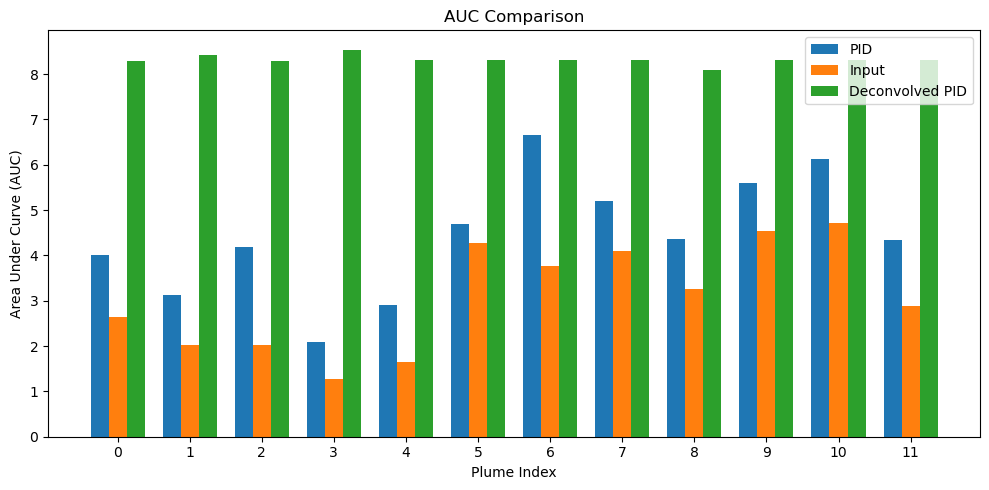

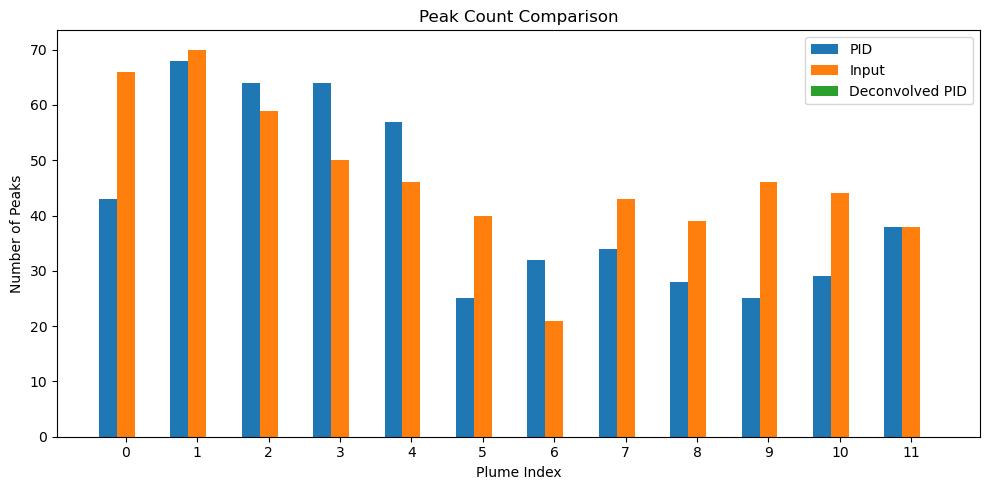

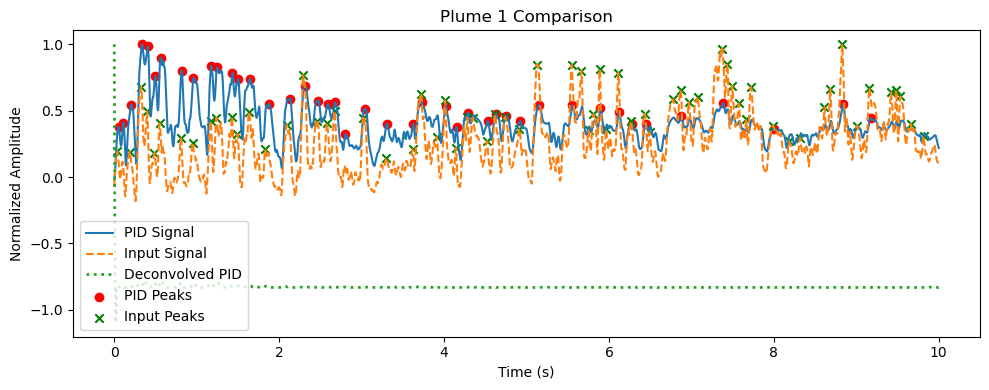

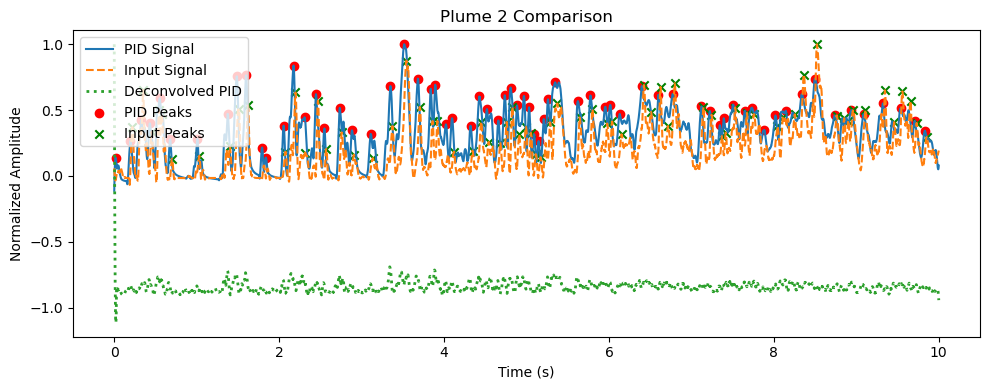

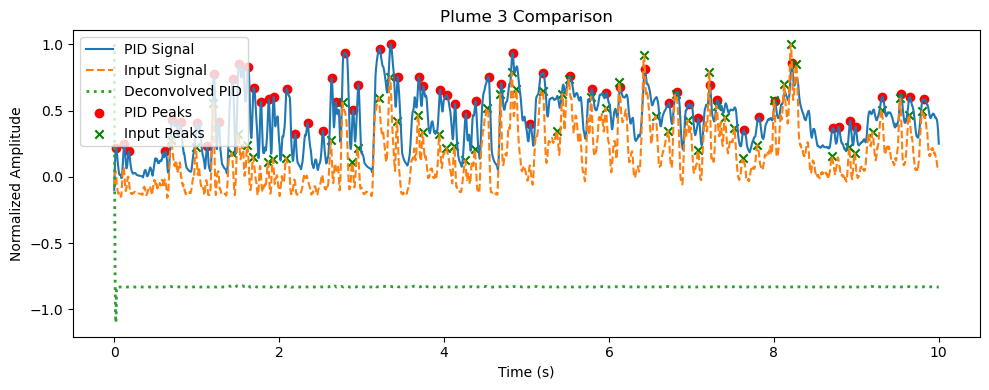

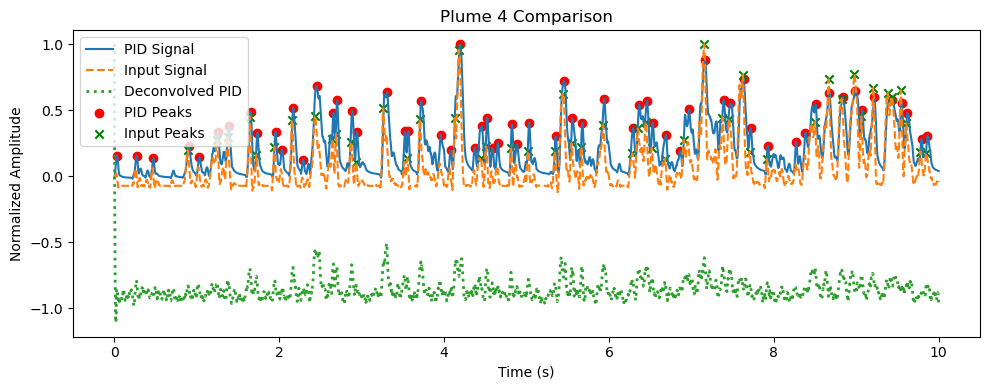

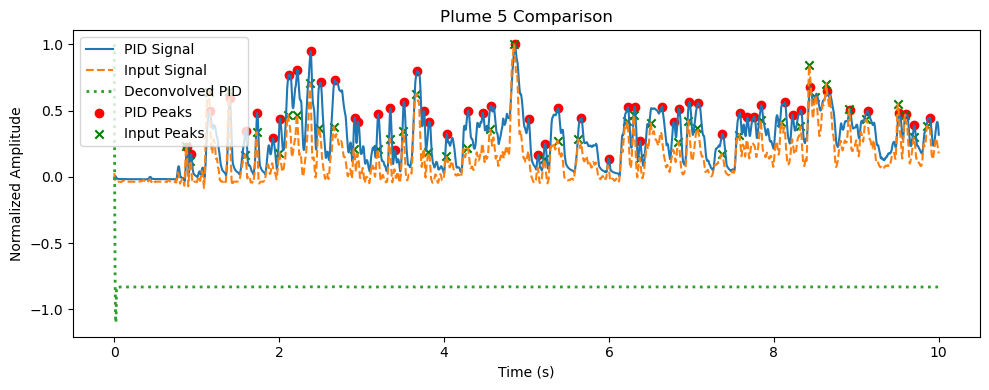

In [9]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
from scipy.fft import fft, ifft
from scipy.ndimage import gaussian_filter1d
from glob import glob

# Configuration Flags
CONFIG = {
    'BASELINE_CORRECTION': True,
    'SMOOTHING': True,
    'NORMALIZATION': True,
    'PEAK_DETECTION': True,
    'DECONVOLUTION': True,         # Enable deconvolution analysis
    'PLOT_SIGNALS': True,          # Plot signal comparisons
    'PLOT_METRICS': True,          # Plot AUC and peak metrics
    'MAX_PLOTS': 5,                # Max plumes to plot
    'CALIBRATE_DECONV': True       # Calibrate deconvolved amplitude
}

# Constants
SAMPLE_RATE = 10000  # Hz
DURATION_S = 10      # Plume duration in seconds
BL_POINTS = 100      # Baseline correction points
WINDOW_LEN = 500     # Savitzky-Golay window length
POLY_ORDER = 3       # Savitzky-Golay polynomial order

# Processing parameters
PID_PARAMS = {
    'THRESH': 0.1,   # Peak detection threshold ratio
    'PROM': 0.1,     # Minimum peak prominence
    'MIN_DIST': 0.02  # Minimum peak distance (s)
}

INPUT_PARAMS = {
    'THRESH': 0.1,   # Peak detection threshold ratio
    'PROM': 0.14,    # Minimum peak prominence
    'MIN_DIST': 0.02  # Minimum peak distance (s)
}

# Deconvolution parameters
DECONV_PARAMS = {
    'method': 'fft',          # 'fft' or 'wiener'
    'kernel_type': 'pid',     # 'pid' or 'mox'
    'tau1': 1.0,              # Decay constant (s)
    'tau2': 0.05,             # Rise constant (s)
    'tau3': 1.0,              # MOX decay constant 1 (s)
    'tau4': 0.05,             # MOX rise constant 1 (s)
    'smooth_sigma': 9,        # Gaussian smoothing sigma
}

def load_pid_data(filepath):
    """Load PID and Input_Pulse data from HDF5 file"""
    with h5py.File(filepath, 'r') as f:
        pid = np.array(f['PID']['values']).squeeze()
        input_pulse = np.array(f['Input_Pulse']['values']).squeeze().astype(float)
    return pid, input_pulse

def load_input_data(filepath):
    """Load input plume data from HDF5 file"""
    with h5py.File(filepath, 'r') as f:
        plume = np.array(f['plume']).squeeze().astype(float)
    return plume

def apply_processing_pipeline(signal, params):
    """Apply processing steps based on configuration flags"""
    time = np.arange(len(signal)) / SAMPLE_RATE
    
    # Processing pipeline
    if CONFIG['BASELINE_CORRECTION']:
        signal = signal - np.mean(signal[:BL_POINTS])
    
    if CONFIG['SMOOTHING']:
        signal = savgol_filter(signal, WINDOW_LEN, POLY_ORDER)
    
    if CONFIG['NORMALIZATION']:
        signal = signal / np.max(np.abs(signal))
    
    # Peak detection
    peaks_df = pd.DataFrame(columns=['time', 'amplitude'])
    if CONFIG['PEAK_DETECTION']:
        height = params['THRESH'] * np.max(signal)
        distance = int(params['MIN_DIST'] * SAMPLE_RATE)
        peaks, _ = find_peaks(signal, height=height, 
                             prominence=params['PROM'], 
                             distance=distance)
        peaks_df = pd.DataFrame({
            'time': time[peaks], 
            'amplitude': signal[peaks]
        })
    
    return time, signal, peaks_df

def calculate_auc(signal, time):
    """Calculate area under the curve using trapezoidal rule"""
    return np.trapz(np.abs(signal), time)

def fft_deconvolution(sensor_signal, sample_rate, params):
    """
    Perform FFT-based deconvolution to recover original signal
    using a physical kernel model of the sensor response
    """
    n = len(sensor_signal)
    t = np.arange(n) / sample_rate
    
    # Create physical kernel model
    if params['kernel_type'] == 'pid':
        # Double exponential kernel for PID sensors
        kernel_vals = np.exp(-t/params['tau1']) - np.exp(-t/params['tau2'])
    else:  # MOX sensor kernel
        kernel_vals = (1/(t*params['tau1'] + 1)) * np.exp(-t/params['tau3']) - \
                      (1/(t*params['tau2'] + 1)) * np.exp(-t/params['tau4'])
    
    # Normalize kernel to preserve signal amplitude
    kernel_vals = kernel_vals / np.sum(kernel_vals)
    
    # FFT-based deconvolution
    fft_sensor = fft(sensor_signal)
    fft_kernel = fft(kernel_vals, n=n)
    
    # Regularized division
    fft_deconvolved = fft_sensor / (fft_kernel + 1e-10)
    deconvolved = np.real(ifft(fft_deconvolved))
    
    # Remove baseline drift
    deconvolved = deconvolved - np.mean(deconvolved[:BL_POINTS])
    
    # Clip negative values
    deconvolved = np.clip(deconvolved, 0, None)
    
    # Apply smoothing
    if params['smooth_sigma'] > 0:
        deconvolved = gaussian_filter1d(deconvolved, sigma=params['smooth_sigma'])
    
    return deconvolved

def calibrate_deconvolved(decon_segments, input_segments):
    """Calibrate deconvolved signals to match input amplitude"""
    calibrated_segments = []
    
    for i in range(min(len(decon_segments), len(input_segments))):
        decon = decon_segments[i]['signal'].copy()
        input_sig = input_segments[i]['signal']
        
        # Calculate scaling factor based on peak amplitudes
        if len(decon_segments[i]['peaks']) > 0 and len(input_segments[i]['peaks']) > 0:
            # Use median peak ratio to avoid outlier sensitivity
            decon_peaks = decon_segments[i]['peaks']['amplitude'].values
            input_peaks = input_segments[i]['peaks']['amplitude'].values
            
            # Find matching peaks within temporal tolerance
            peak_ratios = []
            for t1, a1 in zip(decon_segments[i]['peaks']['time'], decon_peaks):
                for t2, a2 in zip(input_segments[i]['peaks']['time'], input_peaks):
                    if abs(t1 - t2) < 0.1:  # 100ms tolerance
                        if a1 > 0 and a2 > 0:
                            peak_ratios.append(a2 / a1)
            
            if peak_ratios:
                scaling_factor = np.median(peak_ratios)
            else:
                # Fallback to overall signal ratio
                scaling_factor = np.max(input_sig) / np.max(decon)
        else:
            # Fallback to overall signal ratio
            scaling_factor = np.max(input_sig) / np.max(decon)
        
        # Apply calibration
        decon *= scaling_factor
        
        # Update segment data
        calibrated_seg = decon_segments[i].copy()
        calibrated_seg['signal'] = decon
        
        # Recalculate AUC with calibrated signal
        calibrated_seg['auc'] = calculate_auc(decon, calibrated_seg['time'])
        
        # Recalculate peaks if needed
        if CONFIG['PEAK_DETECTION'] and not calibrated_seg['peaks'].empty:
            calibrated_seg['peaks']['amplitude'] = calibrated_seg['peaks']['amplitude'] * scaling_factor
        
        calibrated_segments.append(calibrated_seg)
    
    return calibrated_segments

def process_pid_file(pid_file):
    """Process PID file to extract and process all segments"""
    pid_segments = []
    decon_segments = []
    pid, input_pulse = load_pid_data(pid_file)
    
    # Detect triggers (rising edges)
    threshold = np.mean(input_pulse) + 3 * np.std(input_pulse)
    rising_edges = np.where(np.diff((input_pulse > threshold).astype(int)) == 1)[0]
    
    # Filter triggers to ensure proper spacing
    triggers = []
    if rising_edges.size > 0:
        triggers.append(rising_edges[0])
        for r in rising_edges[1:]:
            if r - triggers[-1] > DURATION_S * SAMPLE_RATE:
                triggers.append(r)
    
    # Process each segment
    for start in triggers:
        end = start + int(DURATION_S * SAMPLE_RATE)
        segment = pid[start:end]
        
        # Standard processing
        time, processed, peaks_df = apply_processing_pipeline(segment, PID_PARAMS)
        pid_segments.append({
            'time': time,
            'signal': processed,
            'peaks': peaks_df,
            'auc': calculate_auc(processed, time)
        })
        
        # Deconvolution processing
        if CONFIG['DECONVOLUTION']:
            # Apply baseline correction for deconvolution input
            segment_bc = segment - np.mean(segment[:BL_POINTS])
            
            # Perform deconvolution
            decon = fft_deconvolution(
                segment_bc, SAMPLE_RATE, DECONV_PARAMS
            )
            
            # Apply post-deconvolution processing
            if CONFIG['SMOOTHING']:
                decon = savgol_filter(decon, WINDOW_LEN, POLY_ORDER)
            
            if CONFIG['BASELINE_CORRECTION']:
                decon = decon - np.mean(decon[:BL_POINTS])
            
            # DO NOT normalize yet - we'll calibrate later
            # Peak detection for deconvolved signal
            peaks_df_decon = pd.DataFrame(columns=['time', 'amplitude'])
            if CONFIG['PEAK_DETECTION']:
                # Use absolute threshold since signal isn't normalized
                height = PID_PARAMS['THRESH'] * np.max(decon)
                distance = int(PID_PARAMS['MIN_DIST'] * SAMPLE_RATE)
                peaks, _ = find_peaks(decon, height=height, 
                                     prominence=PID_PARAMS['PROM'], 
                                     distance=distance)
                peaks_df_decon = pd.DataFrame({
                    'time': time[peaks], 
                    'amplitude': decon[peaks]
                })
            
            decon_segments.append({
                'time': time,
                'signal': decon,
                'peaks': peaks_df_decon,
                'auc': calculate_auc(decon, time)
            })
    
    return pid_segments, decon_segments

def process_input_files(input_folder):
    """Process all input plume files in directory"""
    input_segments = []
    input_files = sorted(glob(os.path.join(input_folder, '*.mat')))
    
    for input_file in input_files:
        plume = load_input_data(input_file)
        time, processed, peaks_df = apply_processing_pipeline(plume, INPUT_PARAMS)
        input_segments.append({
            'time': time,
            'signal': processed,
            'peaks': peaks_df,
            'auc': calculate_auc(processed, time)
        })
    
    return input_segments

def plot_metrics(pid_segments, input_segments, decon_segments=None):
    """Generate metrics comparison plots"""
    num_plumes = min(len(pid_segments), len(input_segments))
    indices = np.arange(num_plumes)
    
    # AUC comparison
    pid_auc = [seg['auc'] for seg in pid_segments[:num_plumes]]
    input_auc = [seg['auc'] for seg in input_segments[:num_plumes]]
    
    plt.figure(figsize=(10, 5))
    width = 0.25
    plt.bar(indices - width, pid_auc, width, label='PID')
    plt.bar(indices, input_auc, width, label='Input')
    
    if decon_segments and len(decon_segments) >= num_plumes:
        decon_auc = [seg['auc'] for seg in decon_segments[:num_plumes]]
        plt.bar(indices + width, decon_auc, width, label='Deconvolved PID')
    
    plt.xlabel('Plume Index')
    plt.ylabel('Area Under Curve (AUC)')
    plt.xticks(indices)
    plt.legend()
    plt.title('AUC Comparison')
    plt.tight_layout()
    plt.show()
    
    # Peak count comparison
    pid_peaks = [len(seg['peaks']) for seg in pid_segments[:num_plumes]]
    input_peaks = [len(seg['peaks']) for seg in input_segments[:num_plumes]]
    
    plt.figure(figsize=(10, 5))
    plt.bar(indices - width, pid_peaks, width, label='PID')
    plt.bar(indices, input_peaks, width, label='Input')
    
    if decon_segments and len(decon_segments) >= num_plumes:
        decon_peaks = [len(seg['peaks']) for seg in decon_segments[:num_plumes]]
        plt.bar(indices + width, decon_peaks, width, label='Deconvolved PID')
    
    plt.xlabel('Plume Index')
    plt.ylabel('Number of Peaks')
    plt.xticks(indices)
    plt.legend()
    plt.title('Peak Count Comparison')
    plt.tight_layout()
    plt.show()

def plot_signal_comparison(pid_seg, input_seg, decon_seg=None, title=''):
    """Plot signal comparison for a single plume"""
    plt.figure(figsize=(10, 4))
    
    # Plot PID and Input signals
    plt.plot(pid_seg['time'], pid_seg['signal'], label='PID Signal')
    plt.plot(input_seg['time'], input_seg['signal'], '--', label='Input Signal')
    
    # Plot deconvolved signal if available
    if decon_seg:
        plt.plot(decon_seg['time'], decon_seg['signal'], ':', 
                label='Deconvolved PID', linewidth=2)
    
    # Plot peaks
    if CONFIG['PEAK_DETECTION']:
        plt.scatter(pid_seg['peaks']['time'], pid_seg['peaks']['amplitude'], 
                    color='red', marker='o', label='PID Peaks')
        plt.scatter(input_seg['peaks']['time'], input_seg['peaks']['amplitude'], 
                    color='green', marker='x', label='Input Peaks')
        
        if decon_seg and not decon_seg['peaks'].empty:
            plt.scatter(decon_seg['peaks']['time'], decon_seg['peaks']['amplitude'], 
                        color='blue', marker='*', s=100, label='Deconvolved Peaks')
    
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Amplitude')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # File paths
    PID_FILE = r"C:\Users\amirr\Documents\Postdoc_Lab\Pub\L15\2-Heptanone\1_100\Plumes_10s.mat"
    INPUT_FOLDER = r"C:\Users\amirr\Documents\Postdoc_Lab\Pub\plumes\Plumes10\pooled"
    
    # Process data
    pid_segments, decon_segments = process_pid_file(PID_FILE)
    input_segments = process_input_files(INPUT_FOLDER)
    
    print(f"Processed {len(pid_segments)} PID segments and {len(input_segments)} input plumes")
    if CONFIG['DECONVOLUTION']:
        print(f"Processed {len(decon_segments)} deconvolved segments")
    
    # Calibrate deconvolved signals to match input amplitude
    if CONFIG['DECONVOLUTION'] and CONFIG['CALIBRATE_DECONV'] and decon_segments:
        decon_segments = calibrate_deconvolved(decon_segments, input_segments)
        print("Applied amplitude calibration to deconvolved signals")
    
    # Calculate and print average AUC
    avg_pid_auc = np.mean([seg['auc'] for seg in pid_segments])
    avg_input_auc = np.mean([seg['auc'] for seg in input_segments])
    print(f"Average PID AUC: {avg_pid_auc:.4f}")
    print(f"Average Input AUC: {avg_input_auc:.4f}")
    
    if CONFIG['DECONVOLUTION'] and decon_segments:
        avg_decon_auc = np.mean([seg['auc'] for seg in decon_segments])
        print(f"Average Deconvolved AUC: {avg_decon_auc:.4f}")
    
    # Generate plots
    if CONFIG['PLOT_METRICS']:
        plot_metrics(pid_segments, input_segments, decon_segments if CONFIG['DECONVOLUTION'] else None)
    
    if CONFIG['PLOT_SIGNALS']:
        num_plots = min(CONFIG['MAX_PLOTS'], len(pid_segments), len(input_segments))
        for idx in range(num_plots):
            decon = decon_segments[idx] if CONFIG['DECONVOLUTION'] and idx < len(decon_segments) else None
            plot_signal_comparison(
                pid_segments[idx], 
                input_segments[idx], 
                decon,
                title=f'Plume {idx + 1} Comparison'
            )

In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

def load_input_data(filepath):
    """Load input plume data from HDF5 file"""
    with h5py.File(filepath, 'r') as f:
        plume = np.array(f['plume']).squeeze().astype(float)
    return plume

# List all .mat files in the folder to help you pick the correct file
input_folder = r"C:\Users\amirr\Documents\Postdoc_Lab\Pub\plumes\Plumes10\pooled"
print("Available files:", os.listdir(input_folder))

# Set your actual file name here (replace with a real file name from the list above)
input_file = os.path.join(input_folder, "plume10s_D30_v73_046.mat")  # <-- change this

# Load raw input signal
raw_signal = load_input_data(input_file)

# Smooth the signal (optional)
WINDOW_LEN = 500  # adjust as needed
POLY_ORDER = 3
smoothed_signal = savgol_filter(raw_signal, WINDOW_LEN, POLY_ORDER)

# Time axis
SAMPLE_RATE = 10000  # Hz, adjust if needed
time = np.arange(len(raw_signal)) / SAMPLE_RATE

# Plot raw and smoothed signals
plt.figure(figsize=(12, 5))
plt.plot(time, raw_signal, label='Raw Input Signal')
plt.plot(time, smoothed_signal, label='Smoothed Input Signal', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Raw and Smoothed Input Signal')
plt.legend()
plt.tight_layout()
plt.show()

Processed 12 PID segments and 12 input plumes

Average PID AUC: 4.4411
Average Input AUC: 3.3548
Average PID Peaks: 42.2
Average Input Peaks: 49.2


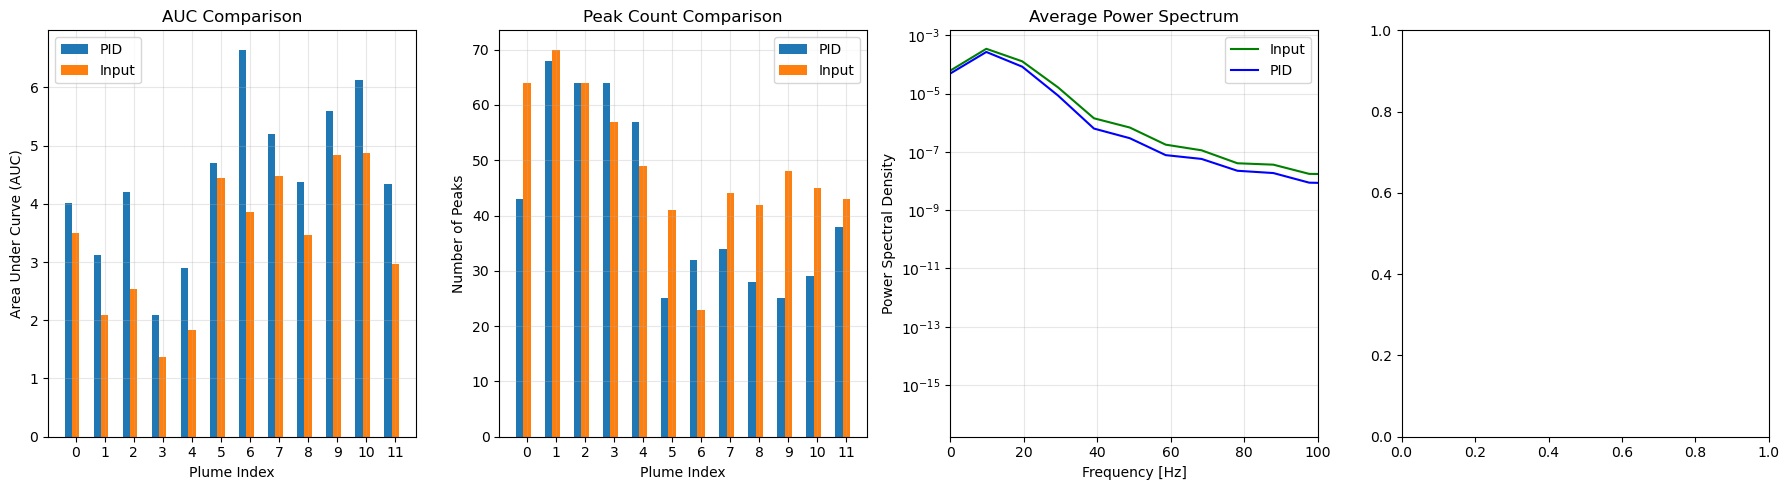

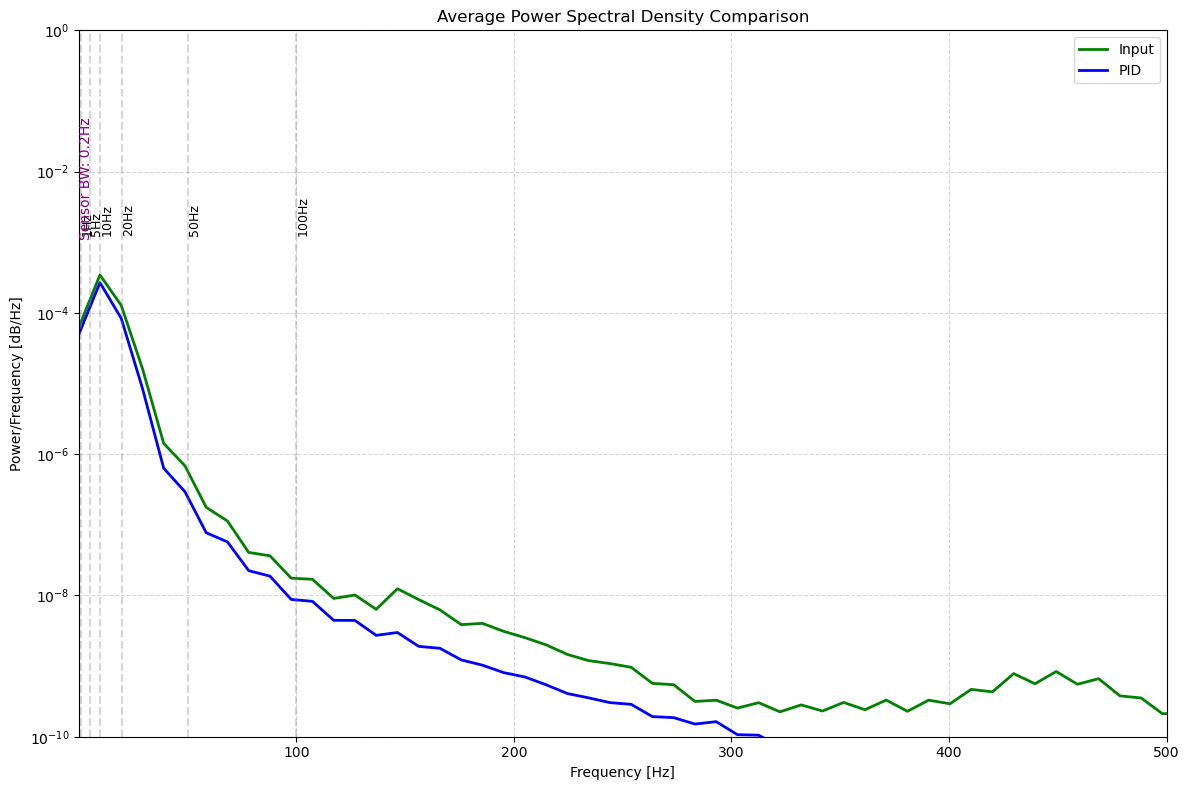

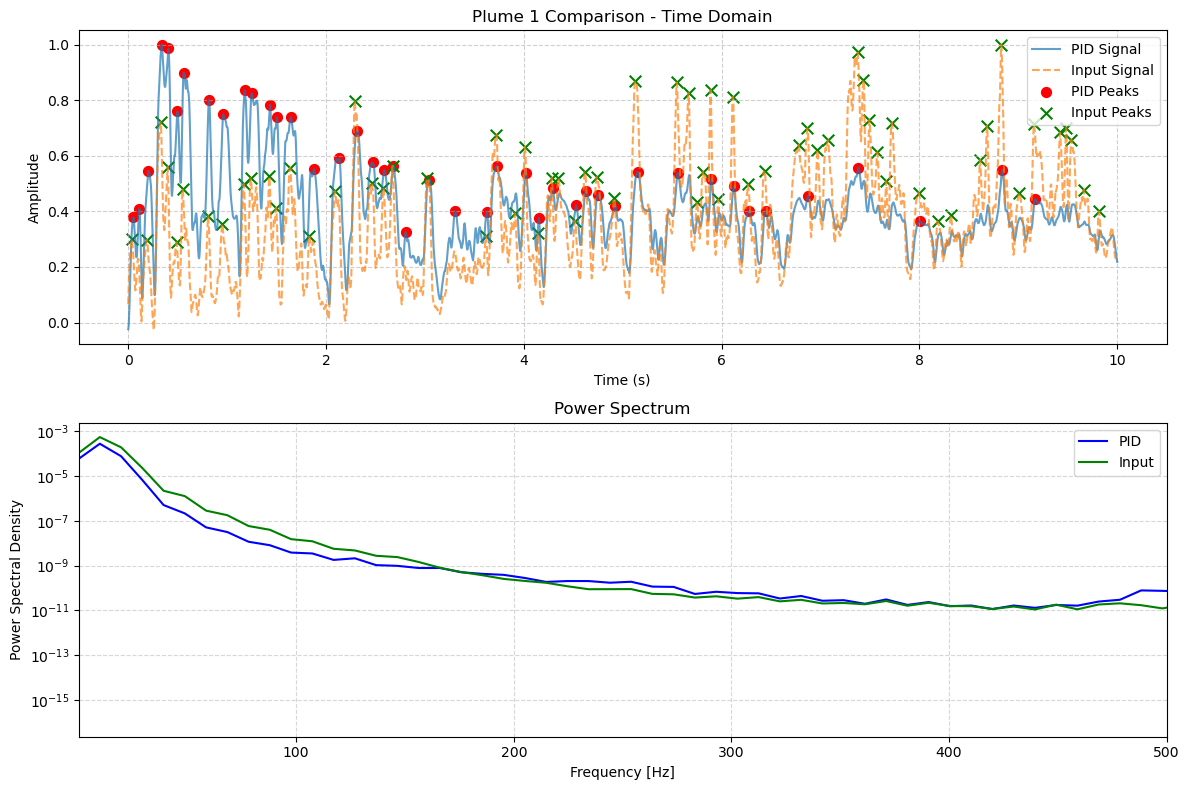

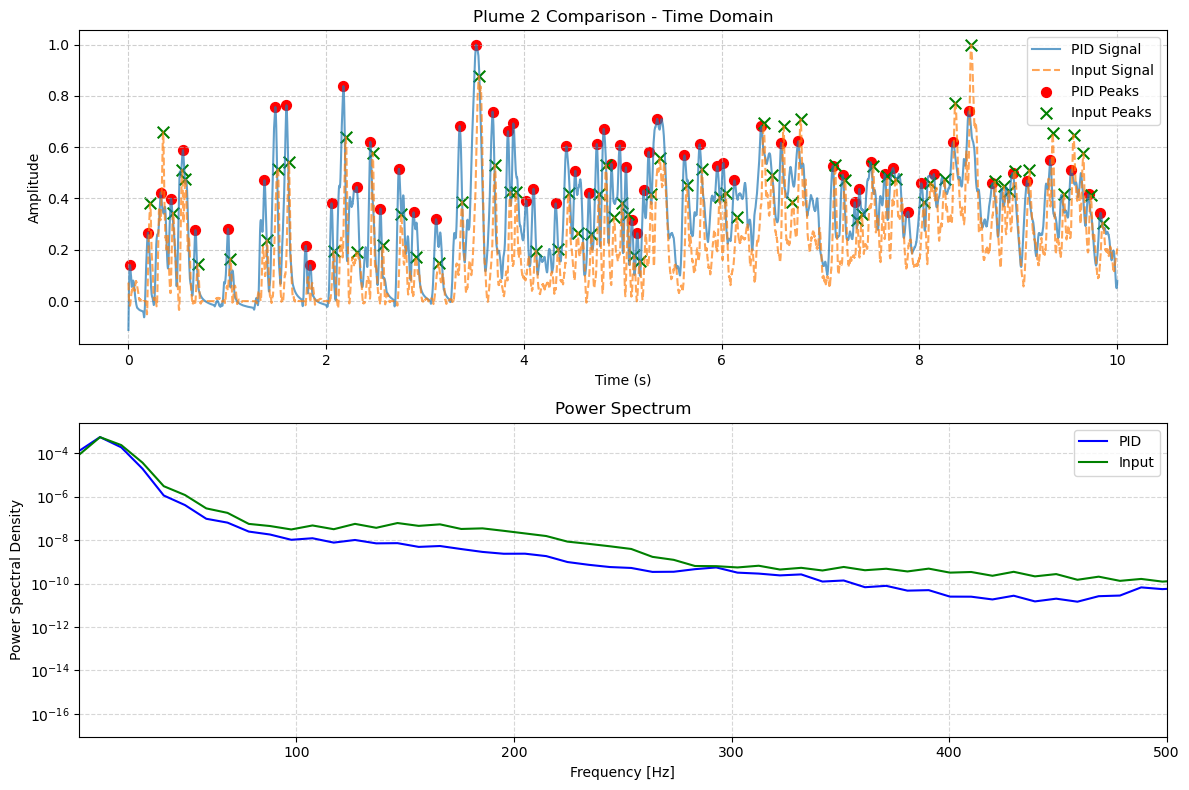

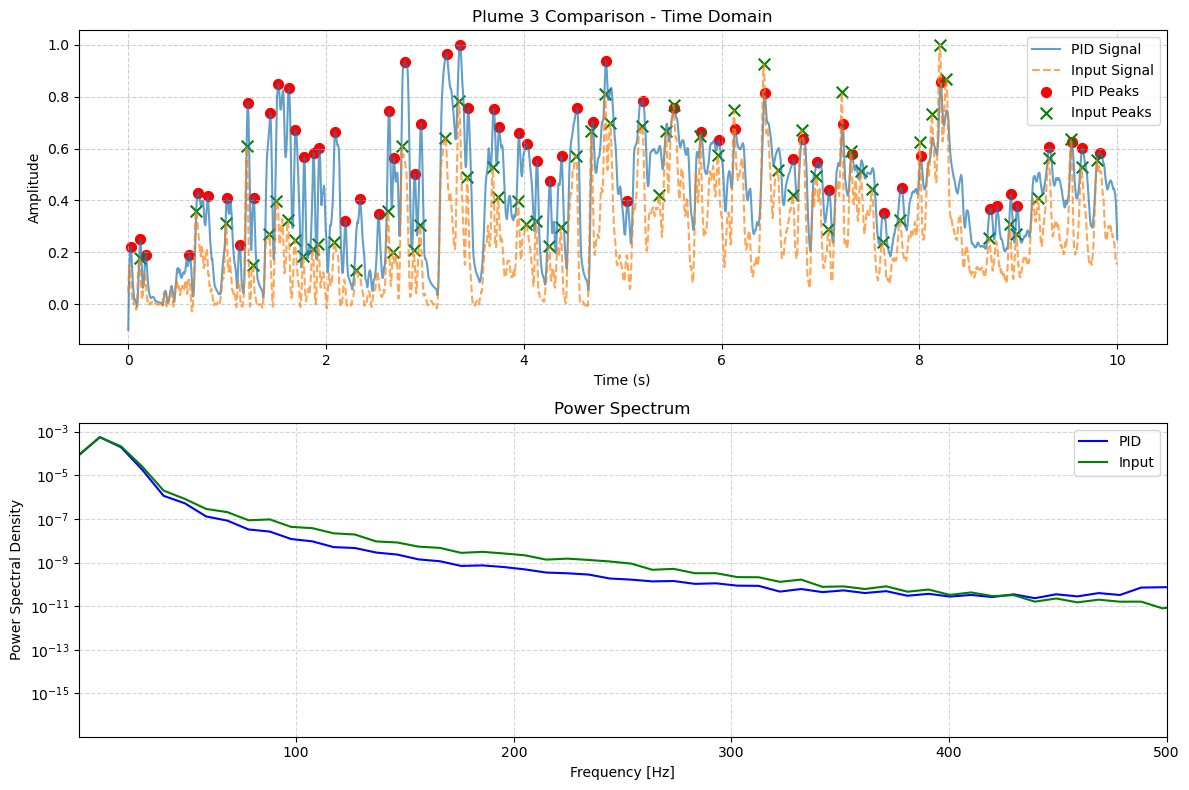

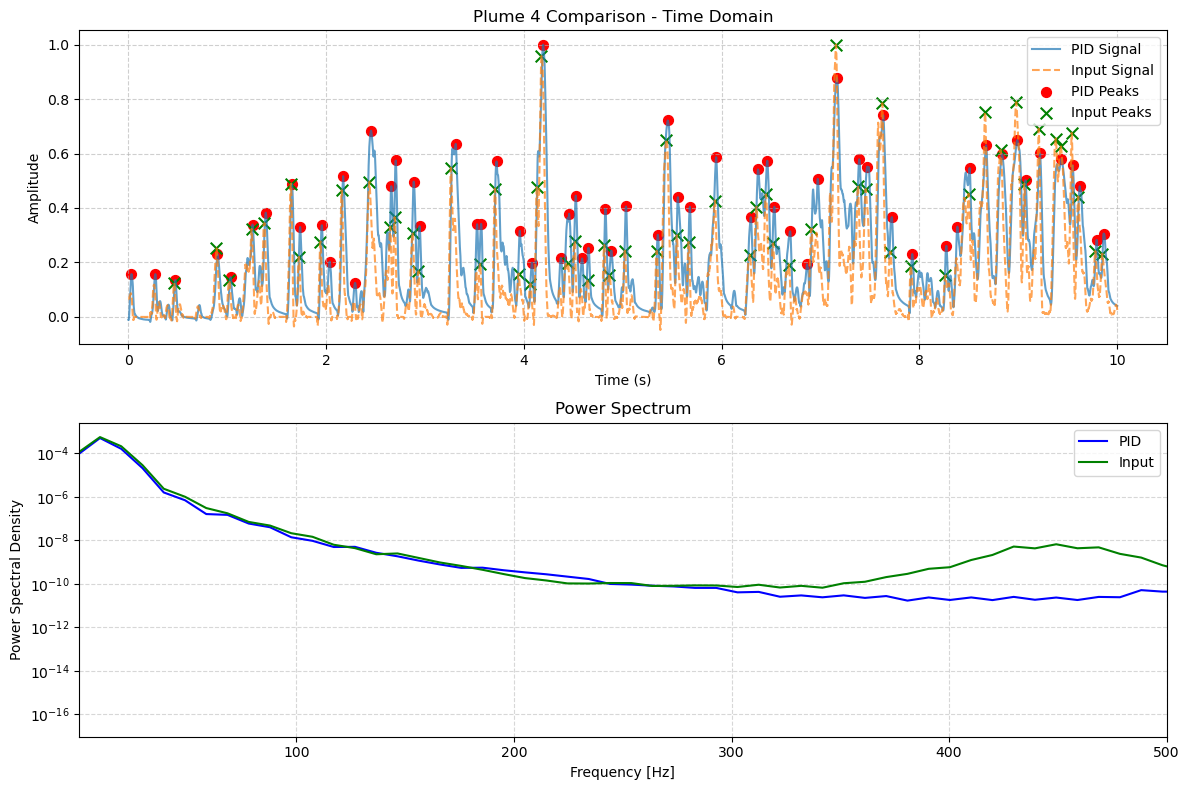

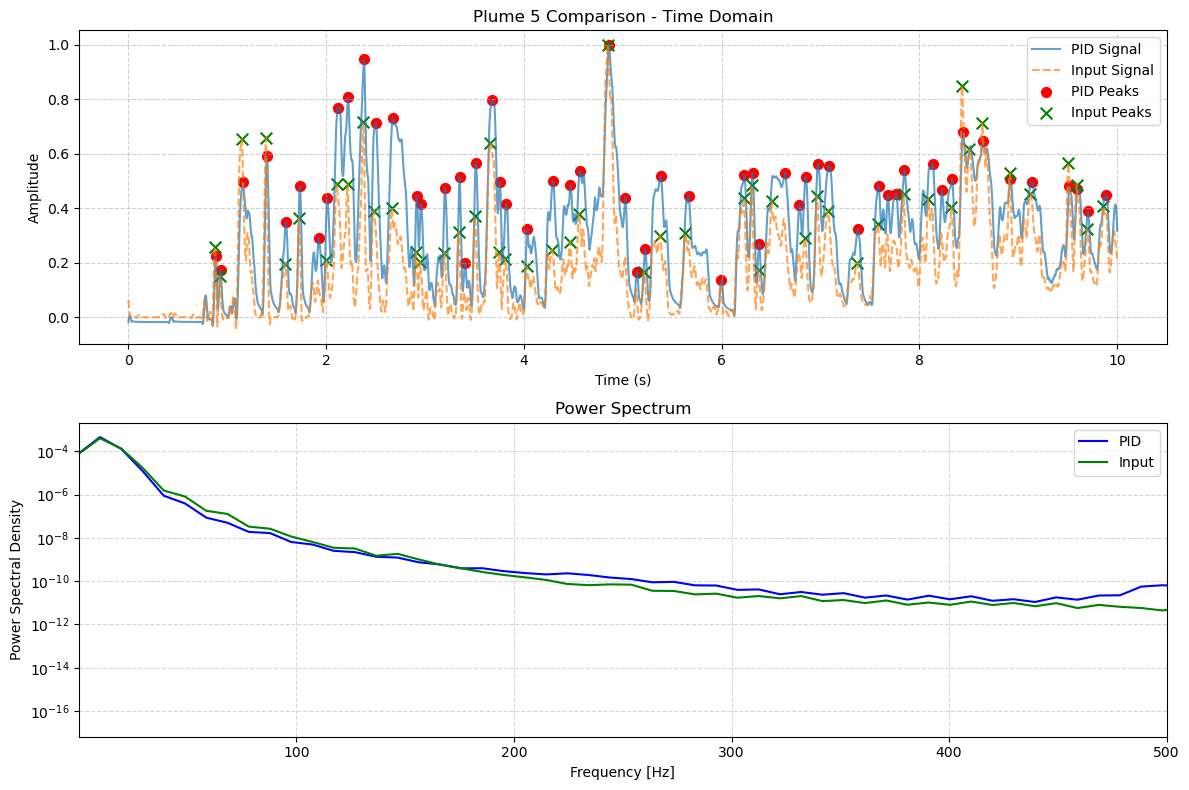

In [16]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter, welch
from scipy.fft import fft, ifft
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import minimize_scalar
from glob import glob

# Configuration Flags
CONFIG = {
    'BASELINE_CORRECTION': True,
    'SMOOTHING': True,
    'NORMALIZATION': True,
    'PEAK_DETECTION': True,
    'DECONVOLUTION': False,         # Enable deconvolution analysis
    'PLOT_SIGNALS': True,          # Plot signal comparisons
    'PLOT_METRICS': True,          # Plot AUC and peak metrics
    'PLOT_PSD': True,              # Plot power spectral density
    'MAX_PLOTS': 5,                # Max plumes to plot
    'CALIBRATE_DECONV': True,      # Calibrate deconvolved amplitude
    'NON_NEGATIVE_DECONV': True    # Enforce non-negative deconvolution
}

# Constants
SAMPLE_RATE = 10000  # Hz
DURATION_S = 10      # Plume duration in seconds
BL_POINTS = 100      # Baseline correction points
WINDOW_LEN = 500     # Savitzky-Golay window length
POLY_ORDER = 3       # Savitzky-Golay polynomial order
PSD_NPERSEG = 1024   # Segment length for PSD calculation

# Processing parameters
PID_PARAMS = {
    'THRESH': 0.1,   # Peak detection threshold ratio
    'PROM': 0.1,     # Minimum peak prominence
    'MIN_DIST': 0.02  # Minimum peak distance (s)
}

INPUT_PARAMS = {
    'THRESH': 0.1,   # Peak detection threshold ratio
    'PROM': 0.13,    # Minimum peak prominence
    'MIN_DIST': 0.02  # Minimum peak distance (s)
}

# Deconvolution parameters
DECONV_PARAMS = {
    'kernel_type': 'pid',     # 'pid' or 'mox'
    'tau1': 1.0,              # Decay constant (s)
    'tau2': 0.05,             # Rise constant (s)
    'tau3': 1.0,              # MOX decay constant 1 (s)
    'tau4': 0.05,             # MOX rise constant 1 (s)
    'smooth_sigma': 5,        # Reduced smoothing for better peak preservation
    'reg_param': 1e-8         # Regularization parameter to prevent noise amplification
}

def load_pid_data(filepath):
    """Load PID and Input_Pulse data from HDF5 file"""
    with h5py.File(filepath, 'r') as f:
        pid = np.array(f['PID']['values']).squeeze()
        input_pulse = np.array(f['Input_Pulse']['values']).squeeze().astype(float)
    return pid, input_pulse

def load_input_data(filepath):
    """Load input plume data from HDF5 file"""
    with h5py.File(filepath, 'r') as f:
        plume = np.array(f['plume']).squeeze().astype(float)
    return plume

def apply_processing_pipeline(signal, params, baseline_correction=True):
    """Apply processing steps based on configuration flags"""
    time = np.arange(len(signal)) / SAMPLE_RATE
    
    # Processing pipeline
    if baseline_correction and CONFIG['BASELINE_CORRECTION']:
        signal = signal - np.mean(signal[:BL_POINTS])
    
    if CONFIG['SMOOTHING']:
        signal = savgol_filter(signal, WINDOW_LEN, POLY_ORDER)
    
    if CONFIG['NORMALIZATION']:
        signal = signal / np.max(np.abs(signal))
    
    # Peak detection
    peaks_df = pd.DataFrame(columns=['time', 'amplitude'])
    if CONFIG['PEAK_DETECTION']:
        height = params['THRESH'] * np.max(signal)
        distance = int(params['MIN_DIST'] * SAMPLE_RATE)
        peaks, _ = find_peaks(signal, height=height, 
                             prominence=params['PROM'], 
                             distance=distance)
        peaks_df = pd.DataFrame({
            'time': time[peaks], 
            'amplitude': signal[peaks]
        })
    
    return time, signal, peaks_df

def calculate_auc(signal, time):
    """Calculate area under the curve using trapezoidal rule"""
    # Only integrate positive parts for deconvolved signals
    positive_signal = np.maximum(signal, 0)
    return np.trapz(positive_signal, time)

def compute_psd(signal, fs=SAMPLE_RATE, nperseg=PSD_NPERSEG):
    """Compute power spectral density using Welch's method"""
    freqs, psd = welch(signal, fs=fs, nperseg=nperseg)
    return freqs, psd

def fft_deconvolution(sensor_signal, sample_rate, params):
    """
    Perform FFT-based deconvolution to recover original signal
    using a physical kernel model of the sensor response
    """
    n = len(sensor_signal)
    t = np.arange(n) / sample_rate
    
    # Create physical kernel model
    if params['kernel_type'] == 'pid':
        # Double exponential kernel for PID sensors
        kernel_vals = np.exp(-t/params['tau1']) - np.exp(-t/params['tau2'])
    else:  # MOX sensor kernel
        kernel_vals = (1/(t*params['tau1'] + 1)) * np.exp(-t/params['tau3']) - \
                      (1/(t*params['tau2'] + 1)) * np.exp(-t/params['tau4'])
    
    # Normalize kernel to unit area
    kernel_vals /= np.sum(kernel_vals)
    
    # FFT-based deconvolution
    fft_sensor = fft(sensor_signal)
    fft_kernel = fft(kernel_vals, n=n)
    
    # Regularized division with Wiener-like conditioning
    H_mag_sq = np.abs(fft_kernel)**2
    regularization = params['reg_param'] * np.max(H_mag_sq)
    fft_deconvolved = fft_sensor * np.conj(fft_kernel) / (H_mag_sq + regularization)
    
    deconvolved = np.real(ifft(fft_deconvolved))
    
    # Remove baseline drift
    baseline = np.mean(deconvolved[:BL_POINTS])
    deconvolved -= baseline
    
    # Enforce non-negativity constraint
    if CONFIG['NON_NEGATIVE_DECONV']:
        deconvolved = np.maximum(deconvolved, 0)
    
    # Apply smoothing
    if params['smooth_sigma'] > 0:
        deconvolved = gaussian_filter1d(deconvolved, sigma=params['smooth_sigma'])
    
    return deconvolved

def calibrate_deconvolved(decon_segments, input_segments):
    """Calibrate deconvolved signals to match input amplitude using AUC minimization"""
    calibrated_segments = []
    
    for i in range(min(len(decon_segments), len(input_segments))):
        decon = decon_segments[i]['signal'].copy()
        input_sig = input_segments[i]['signal']
        time = decon_segments[i]['time']
        
        # Find the scaling factor that minimizes AUC difference
        def auc_error(scale):
            scaled = decon * scale
            return abs(calculate_auc(scaled, time) - calculate_auc(input_sig, time))
        
        # Optimize scaling factor
        result = minimize_scalar(auc_error, bounds=(0.1, 10), method='bounded')
        scaling_factor = result.x
        
        # Apply calibration
        decon *= scaling_factor
        
        # Update segment data
        calibrated_seg = decon_segments[i].copy()
        calibrated_seg['signal'] = decon
        
        # Recalculate AUC with calibrated signal
        calibrated_seg['auc'] = calculate_auc(decon, time)
        
        # Recalculate peaks with updated amplitude
        if CONFIG['PEAK_DETECTION'] and not calibrated_seg['peaks'].empty:
            calibrated_seg['peaks']['amplitude'] *= scaling_factor
        
        calibrated_segments.append(calibrated_seg)
    
    return calibrated_segments

def process_pid_file(pid_file):
    """Process PID file to extract and process all segments"""
    pid_segments = []
    decon_segments = []
    pid, input_pulse = load_pid_data(pid_file)
    
    # Detect triggers (rising edges)
    threshold = np.mean(input_pulse) + 3 * np.std(input_pulse)
    rising_edges = np.where(np.diff((input_pulse > threshold).astype(int)) == 1)[0]
    
    # Filter triggers to ensure proper spacing
    triggers = []
    if rising_edges.size > 0:
        triggers.append(rising_edges[0])
        for r in rising_edges[1:]:
            if r - triggers[-1] > DURATION_S * SAMPLE_RATE:
                triggers.append(r)
    
    # Process each segment
    for start in triggers:
        end = start + int(DURATION_S * SAMPLE_RATE)
        segment = pid[start:end]
        
        # Standard processing
        time, processed, peaks_df = apply_processing_pipeline(segment, PID_PARAMS)
        
        # Compute PSD
        freqs, psd = compute_psd(processed)
        
        pid_segments.append({
            'time': time,
            'signal': processed,
            'peaks': peaks_df,
            'auc': calculate_auc(processed, time),
            'psd_freqs': freqs,
            'psd': psd
        })
        
        # Deconvolution processing
        if CONFIG['DECONVOLUTION']:
            # Apply baseline correction for deconvolution input
            segment_bc = segment - np.mean(segment[:BL_POINTS])
            
            # Perform deconvolution
            decon = fft_deconvolution(segment_bc, SAMPLE_RATE, DECONV_PARAMS)
            
            # Apply post-deconvolution processing
            if CONFIG['BASELINE_CORRECTION']:
                decon = decon - np.mean(decon[:BL_POINTS])
            
            # Peak detection for deconvolved signal
            peaks_df_decon = pd.DataFrame(columns=['time', 'amplitude'])
            if CONFIG['PEAK_DETECTION']:
                # Use absolute threshold since signal isn't normalized
                height = PID_PARAMS['THRESH'] * np.max(decon)
                distance = int(PID_PARAMS['MIN_DIST'] * SAMPLE_RATE)
                peaks, _ = find_peaks(decon, height=height, 
                                     prominence=PID_PARAMS['PROM'], 
                                     distance=distance)
                peaks_df_decon = pd.DataFrame({
                    'time': time[peaks], 
                    'amplitude': decon[peaks]
                })
            
            # Compute PSD for deconvolved signal
            freqs_decon, psd_decon = compute_psd(decon)
            
            decon_segments.append({
                'time': time,
                'signal': decon,
                'peaks': peaks_df_decon,
                'auc': calculate_auc(decon, time),
                'psd_freqs': freqs_decon,
                'psd': psd_decon
            })
    
    return pid_segments, decon_segments

def process_input_files(input_folder):
    """Process all input plume files in directory"""
    input_segments = []
    input_files = sorted(glob(os.path.join(input_folder, '*.mat')))
    
    for input_file in input_files:
        plume = load_input_data(input_file)
        time, processed, peaks_df = apply_processing_pipeline(plume, INPUT_PARAMS, baseline_correction=False)
        
        # Compute PSD
        freqs, psd = compute_psd(processed)
        
        input_segments.append({
            'time': time,
            'signal': processed,
            'peaks': peaks_df,
            'auc': calculate_auc(processed, time),
            'psd_freqs': freqs,
            'psd': psd
        })
    
    return input_segments

def plot_metrics(pid_segments, input_segments, decon_segments=None):
    """Generate metrics comparison plots"""
    num_plumes = min(len(pid_segments), len(input_segments))
    indices = np.arange(num_plumes)
    
    # Create figure with subplots
    plt.figure(figsize=(18, 5))
    
    # AUC comparison
    plt.subplot(1, 4, 1)
    pid_auc = [seg['auc'] for seg in pid_segments[:num_plumes]]
    input_auc = [seg['auc'] for seg in input_segments[:num_plumes]]
    
    width = 0.25
    plt.bar(indices - width, pid_auc, width, label='PID')
    plt.bar(indices, input_auc, width, label='Input')
    
    if decon_segments and len(decon_segments) >= num_plumes:
        decon_auc = [seg['auc'] for seg in decon_segments[:num_plumes]]
        plt.bar(indices + width, decon_auc, width, label='Deconvolved PID')
    
    plt.xlabel('Plume Index')
    plt.ylabel('Area Under Curve (AUC)')
    plt.xticks(indices)
    plt.legend()
    plt.title('AUC Comparison')
    plt.grid(True, alpha=0.3)
    
    # Peak count comparison
    plt.subplot(1, 4, 2)
    pid_peaks = [len(seg['peaks']) for seg in pid_segments[:num_plumes]]
    input_peaks = [len(seg['peaks']) for seg in input_segments[:num_plumes]]
    
    plt.bar(indices - width, pid_peaks, width, label='PID')
    plt.bar(indices, input_peaks, width, label='Input')
    
    if decon_segments and len(decon_segments) >= num_plumes:
        decon_peaks = [len(seg['peaks']) for seg in decon_segments[:num_plumes]]
        plt.bar(indices + width, decon_peaks, width, label='Deconvolved PID')
    
    plt.xlabel('Plume Index')
    plt.ylabel('Number of Peaks')
    plt.xticks(indices)
    plt.legend()
    plt.title('Peak Count Comparison')
    plt.grid(True, alpha=0.3)
    
    # Average PSD comparison
    plt.subplot(1, 4, 3)
    
    # Input PSD
    input_psd_avg = np.mean([seg['psd'] for seg in input_segments[:num_plumes]], axis=0)
    input_freqs = input_segments[0]['psd_freqs']
    plt.semilogy(input_freqs, input_psd_avg, label='Input', color='green')
    
    # PID PSD
    pid_psd_avg = np.mean([seg['psd'] for seg in pid_segments[:num_plumes]], axis=0)
    pid_freqs = pid_segments[0]['psd_freqs']
    plt.semilogy(pid_freqs, pid_psd_avg, label='PID', color='blue')
    
    # Deconvolved PSD
    if decon_segments and len(decon_segments) >= num_plumes:
        decon_psd_avg = np.mean([seg['psd'] for seg in decon_segments[:num_plumes]], axis=0)
        decon_freqs = decon_segments[0]['psd_freqs']
        plt.semilogy(decon_freqs, decon_psd_avg, label='Deconvolved PID', color='red')
    
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Power Spectral Density')
    plt.title('Average Power Spectrum')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 100)  # Focus on relevant frequency range
    
    # Cumulative PSD comparison
    plt.subplot(1, 4, 4)
    if decon_segments and len(decon_segments) >= num_plumes:
        # Calculate cumulative power
        input_cum_power = np.cumsum(input_psd_avg) / np.sum(input_psd_avg)
        pid_cum_power = np.cumsum(pid_psd_avg) / np.sum(pid_psd_avg)
        decon_cum_power = np.cumsum(decon_psd_avg) / np.sum(decon_psd_avg)
        
        plt.plot(input_freqs, input_cum_power, label='Input', color='green')
        plt.plot(pid_freqs, pid_cum_power, label='PID', color='blue')
        plt.plot(decon_freqs, decon_cum_power, label='Deconvolved PID', color='red')
        
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Cumulative Power Fraction')
        plt.title('Cumulative Power Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xlim(0, 100)
    
    plt.tight_layout()
    plt.show()

def plot_psd_comparison(pid_segments, input_segments, decon_segments=None):
    """Detailed PSD comparison plot"""
    num_plumes = min(len(pid_segments), len(input_segments))
    
    plt.figure(figsize=(12, 8))
    
    # Input PSD
    input_psd_avg = np.mean([seg['psd'] for seg in input_segments[:num_plumes]], axis=0)
    input_freqs = input_segments[0]['psd_freqs']
    plt.semilogy(input_freqs, input_psd_avg, label='Input', color='green', linewidth=2)
    
    # PID PSD
    pid_psd_avg = np.mean([seg['psd'] for seg in pid_segments[:num_plumes]], axis=0)
    pid_freqs = pid_segments[0]['psd_freqs']
    plt.semilogy(pid_freqs, pid_psd_avg, label='PID', color='blue', linewidth=2)
    
    # Deconvolved PSD
    if decon_segments and len(decon_segments) >= num_plumes:
        decon_psd_avg = np.mean([seg['psd'] for seg in decon_segments[:num_plumes]], axis=0)
        decon_freqs = decon_segments[0]['psd_freqs']
        plt.semilogy(decon_freqs, decon_psd_avg, label='Deconvolved PID', color='red', linewidth=2)
    
    # Add vertical lines at key frequencies
    key_freqs = [1, 5, 10, 20, 50, 100]
    for freq in key_freqs:
        plt.axvline(x=freq, color='gray', linestyle='--', alpha=0.3)
        plt.text(freq, plt.ylim()[1]*0.9, f'{freq}Hz', rotation=90, fontsize=9)
    
    # Highlight sensor bandwidth
    tau = DECONV_PARAMS['tau1']  # Sensor time constant
    sensor_bandwidth = 1/(2*np.pi*tau)  # Approximate bandwidth
    plt.axvline(x=sensor_bandwidth, color='purple', linestyle='-', alpha=0.7)
    plt.text(sensor_bandwidth, plt.ylim()[1]*0.8, f'Sensor BW: {sensor_bandwidth:.1f}Hz', 
             rotation=90, color='purple')
    
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Power/Frequency [dB/Hz]')
    plt.title('Average Power Spectral Density Comparison')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.xlim(0.1, 500)  # Focus on relevant frequency range
    plt.ylim(1e-10, 1e0)  # Adjust based on your signal characteristics
    
    plt.tight_layout()
    plt.show()

def plot_signal_comparison(pid_seg, input_seg, decon_seg=None, title=''):
    """Plot signal comparison for a single plume"""
    plt.figure(figsize=(12, 8))
    
    # Time domain signals
    plt.subplot(2, 1, 1)
    plt.plot(pid_seg['time'], pid_seg['signal'], label='PID Signal', alpha=0.7)
    plt.plot(input_seg['time'], input_seg['signal'], '--', label='Input Signal', alpha=0.7)
    
    if decon_seg:
        plt.plot(decon_seg['time'], decon_seg['signal'], ':', 
                label='Deconvolved PID', linewidth=2, alpha=0.9)
    
    if CONFIG['PEAK_DETECTION']:
        plt.scatter(pid_seg['peaks']['time'], pid_seg['peaks']['amplitude'], 
                    color='red', marker='o', s=50, label='PID Peaks')
        plt.scatter(input_seg['peaks']['time'], input_seg['peaks']['amplitude'], 
                    color='green', marker='x', s=70, label='Input Peaks')
        
        if decon_seg and not decon_seg['peaks'].empty:
            plt.scatter(decon_seg['peaks']['time'], decon_seg['peaks']['amplitude'], 
                        color='blue', marker='*', s=100, label='Deconvolved Peaks')
    
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'{title} - Time Domain')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Frequency domain comparison
    plt.subplot(2, 1, 2)
    plt.semilogy(pid_seg['psd_freqs'], pid_seg['psd'], label='PID', color='blue')
    plt.semilogy(input_seg['psd_freqs'], input_seg['psd'], label='Input', color='green')
    
    if decon_seg:
        plt.semilogy(decon_seg['psd_freqs'], decon_seg['psd'], label='Deconvolved PID', color='red')
    
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Power Spectral Density')
    plt.title('Power Spectrum')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.xlim(0.1, 500)
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # File paths
    PID_FILE = r"C:\Users\amirr\Documents\Postdoc_Lab\Pub\L15\2-Heptanone\1_100\Plumes_10s.mat"
    INPUT_FOLDER = r"C:\Users\amirr\Documents\Postdoc_Lab\Pub\plumes\Plumes10\pooled"
    
    # Process data
    pid_segments, decon_segments = process_pid_file(PID_FILE)
    input_segments = process_input_files(INPUT_FOLDER)
    
    print(f"Processed {len(pid_segments)} PID segments and {len(input_segments)} input plumes")
    if CONFIG['DECONVOLUTION']:
        print(f"Processed {len(decon_segments)} deconvolved segments")
    
    # Calibrate deconvolved signals to match input amplitude
    if CONFIG['DECONVOLUTION'] and CONFIG['CALIBRATE_DECONV'] and decon_segments:
        decon_segments = calibrate_deconvolved(decon_segments, input_segments)
        print("Applied AUC-based calibration to deconvolved signals")
    
    # Calculate and print average metrics
    avg_pid_auc = np.mean([seg['auc'] for seg in pid_segments])
    avg_input_auc = np.mean([seg['auc'] for seg in input_segments])
    avg_pid_peaks = np.mean([len(seg['peaks']) for seg in pid_segments])
    avg_input_peaks = np.mean([len(seg['peaks']) for seg in input_segments])
    
    print(f"\nAverage PID AUC: {avg_pid_auc:.4f}")
    print(f"Average Input AUC: {avg_input_auc:.4f}")
    print(f"Average PID Peaks: {avg_pid_peaks:.1f}")
    print(f"Average Input Peaks: {avg_input_peaks:.1f}")
    
    if CONFIG['DECONVOLUTION'] and decon_segments:
        avg_decon_auc = np.mean([seg['auc'] for seg in decon_segments])
        avg_decon_peaks = np.mean([len(seg['peaks']) for seg in decon_segments])
        print(f"\nAverage Deconvolved AUC: {avg_decon_auc:.4f}")
        print(f"Average Deconvolved Peaks: {avg_decon_peaks:.1f}")
        print(f"AUC Ratio (Deconvolved/Input): {avg_decon_auc/avg_input_auc:.2f}")
        print(f"Peak Ratio (Deconvolved/Input): {avg_decon_peaks/avg_input_peaks:.2f}")
    
    # Generate plots
    if CONFIG['PLOT_METRICS']:
        plot_metrics(pid_segments, input_segments, decon_segments if CONFIG['DECONVOLUTION'] else None)
    
    if CONFIG['PLOT_PSD']:
        plot_psd_comparison(pid_segments, input_segments, decon_segments if CONFIG['DECONVOLUTION'] else None)
    
    if CONFIG['PLOT_SIGNALS']:
        num_plots = min(CONFIG['MAX_PLOTS'], len(pid_segments), len(input_segments))
        for idx in range(num_plots):
            decon = decon_segments[idx] if CONFIG['DECONVOLUTION'] and idx < len(decon_segments) else None
            plot_signal_comparison(
                pid_segments[idx], 
                input_segments[idx], 
                decon,
                title=f'Plume {idx + 1} Comparison'
            )